In [ ]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from statsbombpy import sb
pd.set_option('display.max_columns', None)
from mplsoccer import Pitch, Sbopen
from mplsoccer import VerticalPitch,Pitch
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
def digraph(data):
        G = nx.DiGraph()
        pass_counts = {}
        players = data["player_name"].unique()
        G.add_nodes_from(players)
        for _, row in data.iterrows():
                key = (row["player_name"], row["pass_recipient_name"])
                if key in pass_counts:
                        pass_counts[key] += 1
                else:
                        pass_counts[key] = 1

        for key, weight in pass_counts.items():
                G.add_edge(key[0], key[1], weight=weight)
        
        return G

In [ ]:
parser = Sbopen()
df_competitions = parser.competition()
df_competitions.head(5)

In [ ]:
teams = parser.match(competition_id=2, season_id=27)
teams

In [ ]:
def get_away_score(match_id, home_team_name):
    event = scores_var(match_id=match_id, home_team=home_team_name)
    
    score_change_indices = event.index[event['home_score_position'] != event['home_score_position'].shift()].tolist()
    
    # Extract the home and away scores at the change indices
    home_scores_at_changes = event.loc[score_change_indices, 'home_score_position']
    away_scores_at_changes = event.loc[score_change_indices, 'away_score_position']
    
    return away_scores_at_changes


In [ ]:
def get_home_score(match_id, home_team_name):
    event = scores_var(match_id=match_id, home_team=home_team_name)
    
    score_change_indices = event.index[event['home_score_position'] != event['home_score_position'].shift()].tolist()
    
    # Extract the home and away scores at the change indices
    home_scores_at_changes = event.loc[score_change_indices, 'home_score_position']
    away_scores_at_changes = event.loc[score_change_indices, 'away_score_position']
     
    return home_scores_at_changes

# Example usage
match_id = 3754245
home_team_name = 'West Bromwich Albion'
home_scores = get_away_score(match_id, home_team_name)
home_scores


In [ ]:


def scores_var(match_id, home_team):
    home = 0
    away = 0
    df, related, freeze, tactics = parser.event(match_id)
    df['home_score_position'] = 'Tie'

    for index, row in df.iterrows():
        if row['outcome_name'] == 'Goal':
            if row['possession_team_name'] == home_team:
                home += 1
            else:
                away += 1

        if home == away:
            df.loc[index, 'home_score_position'] = 'Tie'
        elif home > away:
            df.loc[index, 'home_score_position'] = 'Winning'
        else:
            df.loc[index, 'home_score_position'] = 'Losing'
    df['away_score_position'] = df['home_score_position'].apply(
        lambda x: 'Tie' if x == 'Tie' else ('Winning' if x == 'Losing' else 'Losing')
    )

    return df



event = scores_var(match_id=3754245, home_team='West Bromwich Albion')
event


Now, I need to make the passing networks for each

In [ ]:
def pass_data(match_id, home_team_name, start_min, end_min):
    df, related, freeze, tactics = parser.event(match_id)
    df = df.iloc[start_min:end_min - 1]
    
    sub_df = df.loc[(df["type_name"] == "Substitution") & (df["team_name"] == home_team_name)]

    if not sub_df.empty:
        sub = sub_df.iloc[0]["index"]
        mask = (df["type_name"] == 'Pass') & (df["team_name"] == home_team_name) & (df["index"] < sub) & (df["outcome_name"].isnull()) & (df["sub_type_name"] != "Throw-in")
        df_pass = df.loc[mask, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
        df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
        df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])
    else:
        # Handle the case when there are no substitutions
        mask = (df["type_name"] == 'Pass') & (df["team_name"] == home_team_name) & (df["outcome_name"].isnull())
        df_pass = df.loc[mask, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
        df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
        df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])  # Create an empty DataFrame or define your preferred behavior

    return df_pass



In [ ]:
def avg(dictionary):
    total = sum(dictionary.values())

    average = total / len(dictionary)
    
    return average

In [ ]:
test = teams.head().copy()
test

In [ ]:
def average_degree(G):

    degrees = [degree for node, degree in G.degree()]
    average_degree = sum(degrees) / len(degrees)
    return average_degree


In [ ]:
test_frame = pass_data(3754245, "Sunderland",0,3078)
b = digraph(test_frame)
def average_edge_weight(G):
    total_edges = G.number_of_edges()
    edge_weight_sum = 0

    for edge_data in G.edges(data=True):
        edge_weight_sum += edge_data[2].get('weight', 0.0)

    # Calculate the average edge weight
    average_edge_weight = edge_weight_sum / total_edges
    return average_edge_weight
sum(b.degree)

In [ ]:
def get_data(dat):
    data = pd.DataFrame()

    for index, row in dat.iterrows():
        if not pd.isna(row['home_team_name']):
            match_id = row['match_id']
            home_team_name = row['home_team_name']
            away_team_name = row['away_team_name']
            event = scores_var(match_id=match_id, home_team=home_team_name)
            mask = (event['home_score_position'] != event['home_score_position'].shift())
            change_indices = mask.index[mask].tolist()

            i = 0
            while i < len(change_indices) - 1:
                # Get passing data for home team and away team in the specified time interval
                home_data = pass_data(match_id=match_id, home_team_name=home_team_name, start_min=change_indices[i], end_min=change_indices[i + 1])
                away_data = pass_data(match_id=match_id, home_team_name=away_team_name, start_min=change_indices[i], end_min=change_indices[i + 1])
                
                G_home = digraph(home_data)
                G_away = digraph(away_data)
                away_score = get_away_score(match_id=match_id, home_team_name=home_team_name)
                home_score = get_home_score(match_id=match_id, home_team_name=home_team_name)
                try:
                    betweenness_centrality_home = avg(nx.betweenness_centrality(G_home))
                    eigenvector_centrality_home = max(nx.eigenvector_centrality(G_home, max_iter=1000, tol=1e-3).values())
                    katz_centrality_home = max(nx.katz_centrality(G_home).values())
                except ZeroDivisionError:
                    i += 1
                    continue
                # home graph
                betweenness_centrality_home = avg(nx.betweenness_centrality(G_home))
                eigenvector_centrality_home = max(nx.eigenvector_centrality(G_home, max_iter=1000, tol=1e-3).values())
                katz_centrality_home = max(nx.katz_centrality(G_home).values())
                page_rank_home = max(nx.pagerank(G_home).values())
                
                match_data_home = {
                    'Match ID': match_id,
                    'Team': home_team_name,
                    'Betweenness Centrality': betweenness_centrality_home,
                    'Eigenvector Centrality': eigenvector_centrality_home,
                    'Katz Centrality': katz_centrality_home,
                    'Page Rank': page_rank_home,
                    'Average Clustering': (nx.average_clustering(G_home)),
                    'Score': home_score.iloc[i],
                    'Average Edge Weight' : average_edge_weight(G_home), 
                    'Average Degree Centrality' : avg(nx.degree_centrality(G_home)),
                    'Average in-Degree Centrality' : avg(nx.in_degree_centrality(G_home)),
                    'Average out-Degree Centrality' : avg(nx.out_degree_centrality(G_home)),
                    'Average Closeness Centrality' : avg(nx.closeness_centrality(G_home)),
                    'Average Degree' : average_degree(G_home)



            
                }
                
                try:
                    betweenness_centrality_away = avg(nx.betweenness_centrality(G_away))
                    eigenvector_centrality_away = max(nx.eigenvector_centrality(G_away, max_iter=1000, tol=1e-3).values())
                    katz_centrality_away = max(nx.katz_centrality(G_away).values())
                except ZeroDivisionError:
                    i += 1
                    continue
                page_rank_away = max(nx.pagerank(G_away).values())
                
                match_data_away = {
                    'Match ID': match_id,
                    'Team': away_team_name,
                    'Betweenness Centrality': betweenness_centrality_away,
                    'Eigenvector Centrality': eigenvector_centrality_away,
                    'Katz Centrality': katz_centrality_away,
                    'Page Rank': page_rank_away,
                    'Average Clustering': (nx.average_clustering(G_away)),
                    'Score': away_score.iloc[i],
                    'Average Edge Weight' : average_edge_weight(G_away),
                    'Average Degree Centrality' : avg(nx.degree_centrality(G_away)),
                    'Average in-Degree Centrality' : avg(nx.in_degree_centrality(G_away)),
                    'Average out-Degree Centrality' : avg(nx.out_degree_centrality(G_away)),
                    'Average Closeness Centrality' : avg(nx.closeness_centrality(G_away)),
                    'Average Degree' : average_degree(G_away)



                }
        
                data = data.append(match_data_away, ignore_index=True)
                data = data.append(match_data_home, ignore_index=True)

                i += 1

    return data

new = get_data(dat=teams)
df = new.copy()


### Results for Win, Tie, or Loss

In [666]:
test1

,Match ID,Team,Betweenness Centrality,Eigenvector Centrality,Katz Centrality,Page Rank,Average Clustering,Score,Average Edge Weight,Average Degree Centrality,Average in-Degree Centrality,Average out-Degree Centrality,Average Closeness Centrality,Average Degree
0,3754153,Crystal Palace,0.085714,0.986180,0.414240,0.209236,0.107143,Tie,1.000000,0.333333,0.166667,0.166667,0.250153,2.000000
1,3754050,Sunderland,0.054545,0.395761,0.353813,0.168956,0.594016,Tie,1.741379,1.054545,0.527273,0.527273,0.679362,10.545455
2,3754018,Liverpool,0.059596,0.485744,0.410709,0.157720,0.551622,Tie,1.870370,0.981818,0.490909,0.490909,0.662750,9.818182
3,3754197,Manchester City,0.241667,0.586694,0.355077,0.162780,0.282262,Tie,1.166667,0.400000,0.200000,0.200000,0.358157,3.600000
4,3753994,Southampton,0.040404,0.393528,0.367872,0.132665,0.687141,Tie,2.904110,1.327273,0.663636,0.663636,0.748415,13.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,3754105,Everton,0.048485,0.428991,0.386469,0.173994,0.639237,Losing,2.080645,1.127273,0.563636,0.563636,0.706300,11.272727
473,3753995,Southampton,0.046465,0.353181,0.333089,0.114934,0.603582,Losing,2.046154,1.181818,0.590909,0.590909,0.710512,11.818182
474,3754319,Swansea City,0.105051,0.428267,0.354455,0.139263,0.375233,Losing,1.352941,0.618182,0.309091,0.309091,0.524939,6.181818
475,3754315,AFC Bournemouth,0.086111,0.442662,0.362500,0.177171,0.500705,Losing,1.250000,0.533333,0.266667,0.266667,0.438460,4.800000


In [890]:
test1 = df.copy()

def balanced_data(df):
    ties = test1[test1['Score'] == "Tie"]
    wins = test1[test1['Score'] == "Winning"]
    losses = test1[test1['Score'] == "Losing"]

    min_count = min(len(ties), len(wins), len(losses))

    ties = ties.sample(min_count)
    wins = wins.sample(min_count)
    losses = losses.sample(min_count)

    balanced_data = pd.concat([ties, wins, losses], ignore_index=True)
    return balanced_data
test1 = balanced_data(test1)


# After best subset selection these features perform best for the multinomial models

In [891]:
X = test1[['Eigenvector Centrality', 'Page Rank', 'Average Clustering', 'Average Edge Weight']]

y = test1['Score']

In [892]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_classifier = XGBClassifier()

cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.29850746 0.43283582 0.29850746 0.33333333 0.39393939]
Mean CV Score: 0.35142469470827675
Accuracy on Test Set: 0.3819444444444444
              precision    recall  f1-score   support

      Losing       0.41      0.33      0.36        49
         Tie       0.42      0.39      0.41        56
     Winning       0.32      0.44      0.37        39

    accuracy                           0.38       144
   macro avg       0.38      0.39      0.38       144
weighted avg       0.39      0.38      0.38       144



In [893]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

predicted = cross_val_predict(model, X, y, cv=5)

confusion = confusion_matrix(y, predicted)




Confusion Matrix:
[[60 42 57]
 [44 75 40]
 [58 45 56]]


In [894]:

model = LogisticRegression()

scores = cross_val_score(model, X, y)


print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())


Cross-Validation Scores: [0.35416667 0.46875    0.36842105 0.41052632 0.4       ]
Mean Accuracy: 0.40037280701754385
Standard Deviation: 0.03983615257546849


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import combinations


In [650]:
def fit_logistic_regression(X_train, X_test, y_train, y_test, feature_subset):
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train[feature_subset], y_train)
    y_pred = model.predict(X_test[feature_subset])
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


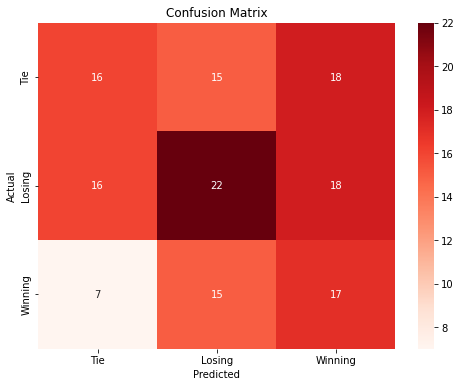

In [895]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['Tie', 'Losing', 'Winning']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## KNN Model 

Optimal k: 12
Accuracy: 0.4513888888888889


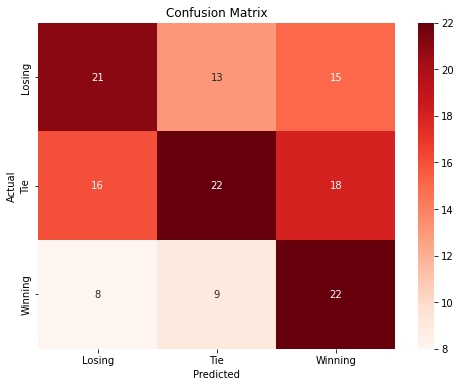

In [903]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k_values = list(range(1, 21))
mean_cv_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=10)  # 5-fold cross-validation
    mean_cv_scores.append(np.mean(cv_scores))

optimal_k = k_values[mean_cv_scores.index(max(mean_cv_scores))]

print("Optimal k:", optimal_k)

knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = list(set(y))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


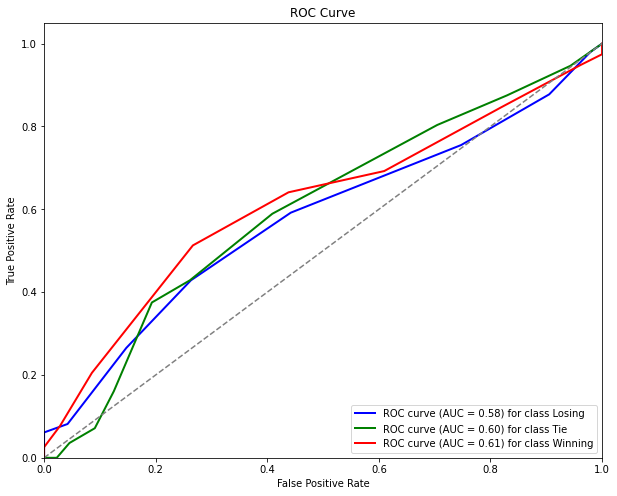

In [904]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer



y_scores = knn_classifier.predict_proba(X_test)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_scores[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for class {class_labels[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.4444444444444444


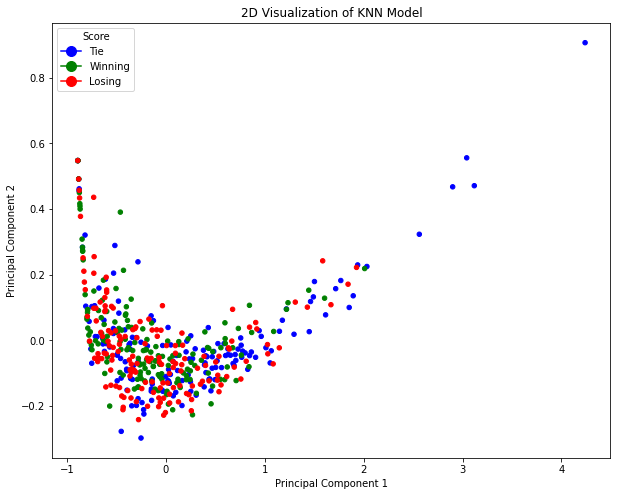

In [905]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.3, random_state=42)

k = 12
knn_classifier = KNeighborsClassifier(n_neighbors=k)

knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

score_mapping = {'Tie': 'blue', 'Winning': 'green', 'Losing': 'red'}
colors = np.array([score_mapping[label] for label in y])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of KNN Model')

legend_labels = ['Tie', 'Winning', 'Losing']
legend_colors = ['blue', 'green', 'red']
handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=handles, title='Score')

plt.show()


In [906]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_classifier = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

xgb_classifier = XGBClassifier(**best_params)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.3888888888888889
              precision    recall  f1-score   support

      Losing       0.38      0.35      0.36        49
         Tie       0.44      0.39      0.42        56
     Winning       0.35      0.44      0.39        39

    accuracy                           0.39       144
   macro avg       0.39      0.39      0.39       144
weighted avg       0.39      0.39      0.39       144



## Dataset with only Wins and Losses

In [907]:
test2 = df.copy()

def balanced_data(df):
    wins = test1[test1['Score'] == "Winning"]
    losses = test1[test1['Score'] == "Losing"]

    min_count = min(len(wins), len(losses))

    wins = wins.sample(min_count)
    losses = losses.sample(min_count)

    balanced_data = pd.concat([ wins, losses], ignore_index=True)
    return balanced_data
test2 = balanced_data(test2)
test2 = test2.sample(frac=1) 
test2.head(10)

,Match ID,Team,Betweenness Centrality,Eigenvector Centrality,Katz Centrality,Page Rank,Average Clustering,Score,Average Edge Weight,Average Degree Centrality,Average in-Degree Centrality,Average out-Degree Centrality,Average Closeness Centrality,Average Degree
184,3754071,Swansea City,0.051515,0.374104,0.344987,0.129219,0.657231,Losing,1.919355,1.127273,0.563636,0.563636,0.694668,11.272727
134,3754315,Norwich City,0.095833,0.595173,0.410224,0.206752,0.308528,Winning,1.368421,0.422222,0.211111,0.211111,0.370007,3.800000
226,3754315,AFC Bournemouth,0.086111,0.442662,0.362500,0.177171,0.500705,Losing,1.250000,0.533333,0.266667,0.266667,0.438460,4.800000
187,3754102,Norwich City,0.125253,0.421894,0.356041,0.167218,0.311855,Losing,1.531250,0.581818,0.290909,0.290909,0.475807,5.818182
96,3754318,Arsenal,0.071717,0.427514,0.363427,0.176569,0.477068,Winning,1.750000,0.800000,0.400000,0.400000,0.552526,8.000000
104,3754243,Norwich City,0.114141,0.433364,0.361606,0.171845,0.348686,Winning,1.525000,0.727273,0.363636,0.363636,0.547832,7.272727
23,3754006,West Bromwich Albion,0.097980,0.475589,0.394549,0.192666,0.489047,Winning,1.447368,0.690909,0.345455,0.345455,0.557256,6.909091
138,3754062,Chelsea,0.079798,0.484267,0.405048,0.206418,0.525300,Winning,1.936170,0.854545,0.427273,0.427273,0.601625,8.545455
191,3754342,Watford,0.095960,0.471413,0.350299,0.212956,0.264714,Losing,1.500000,0.436364,0.218182,0.218182,0.360632,4.363636
246,3754001,Chelsea,0.047475,0.415768,0.381094,0.157645,0.738360,Losing,2.353846,1.181818,0.590909,0.590909,0.715971,11.818182


In [908]:
X = test2[['Eigenvector Centrality', 'Page Rank', 'Average Clustering', 'Average Edge Weight']]

y = test2["Score"]


In [ ]:
def fit_logistic_regression(X_train, X_test, y_train, y_test, feature_subset):
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train[feature_subset], y_train)
    y_pred = model.predict(X_test[feature_subset])
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [919]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

k = 10
knn_classifier = KNeighborsClassifier(n_neighbors=k)

cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=10)  

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)


Cross-Validation Scores: [0.62962963 0.7037037  0.51851852 0.66666667 0.40740741 0.7037037
 0.59259259 0.44444444 0.51851852 0.66666667]
Mean Accuracy: 0.5851851851851851
Standard Deviation: 0.10183501544346313
Accuracy on Test Set: 0.5833333333333334


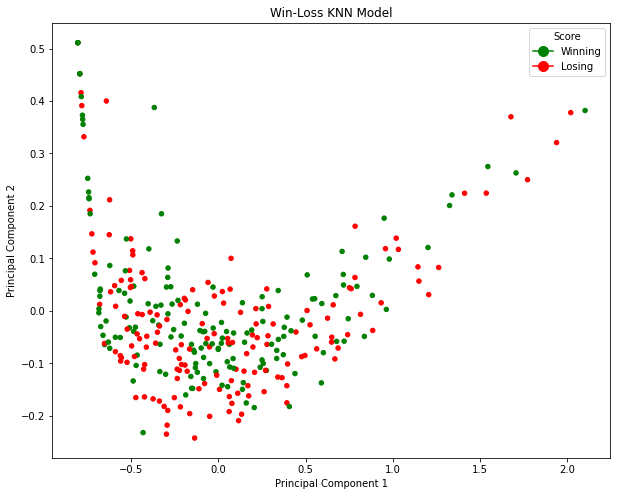

0.5625


In [926]:


pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.25, random_state=42)

k = 10
knn_classifier = KNeighborsClassifier(n_neighbors=k)

knn_classifier.fit(X_train, y_train)

x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

colors = np.array([score_mapping[label] for label in y])
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=20)

plt.xlabel('Principal Component 1')
plt.ylabel ('Principal Component 2')
plt.title('Win-Loss KNN Model')

legend_labels = ['Winning', 'Losing']
legend_colors = ['green', 'red']
handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=handles, title='Score')

plt.show()
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)